In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import imputation
from matplotlib import pyplot as plt

from sklearn.metrics import fbeta_score, make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_val_score

import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline

import xgboost as xgb

In [2]:
def load_and_clean_df(filename):
    _df = pd.read_csv(filename, na_values='na')
    _df = _df.set_index("ID")
    _df = _df.rename({'class':'target'}, axis=1).astype(np.number)
    return _df

def normalize_hist(df, var_group):
    _df = df.copy()
    l_cols_int = [c for c in df.columns if c[:2] == var_group]
    _df[l_cols_int] = _df[l_cols_int].div(_df[l_cols_int].sum(axis=1), axis=0)
    return _df
    
def normalize_histograms_in_df(df):
    l_hist_var_groups = [c[:2] for c in df.columns if c[-1]=="1"]
    output = df.copy()
    for hist_var_group in l_hist_var_groups:
        output = normalize_hist(output, hist_var_group)
    return output

def split_x_y(df, target_col = 'target'):
    return df.drop(target_col,axis=1), df[target_col]

# Loading data

In [3]:
df = load_and_clean_df("../input/training_data_set.csv")
df_test = load_and_clean_df("../input/test_data_set.csv")

df.head()

,target,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,...,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,...,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,...,0.0,2341048.0,1494.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13876.0,38182.0,8138.0,0.0,0.0,65772.0,10534.0,300240.0,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2578.0,76.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,2014.0,370.0,48.0,18.0,15740.0,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,2128914.0,...,0.0,3590004.0,2026.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44946.0,62648.0,11506.0,0.0,0.0,149474.0,35154.0,457040.0,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


# Clean data
> ## Normalize histogram variables

> ## Replace missing values with the mean

> ## Standardize

In [4]:
normalizer = FunctionTransformer(normalize_histograms_in_df, validate=False) 
imputer = imputation.Imputer() 
standardizer = StandardScaler()
data_prep_pipeline = make_pipeline(normalizer, imputer, standardizer)

X_train, X_val, y_train, y_val = train_test_split(*split_x_y(df), test_size=0.2, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# XGB

### Fit

In [5]:
%%time
pos_weight = (df.target==0).sum()/df.target.sum()

m2 = xgb.XGBClassifier(objective='binary:logistic',
                       max_depth=3,
                        learning_rate=0.1,
                        base_score =0.95,
                        gamma=0.3,
                        reg_alpha=0.3,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        n_estimators=500,
                        scale_pos_weight = pos_weight
                        ,n_jobs=4
                        ,gpu_id = 0
                        ,max_bin = 16
                        ,tree_method = 'gpu_hist'
                      )

pipe2 = make_pipeline(normalizer, imputer, standardizer, m2)
pipe2.fit(X_train, y_train)

CPU times: user 2.25 s, sys: 1.47 s, total: 3.72 s
Wall time: 4.65 s


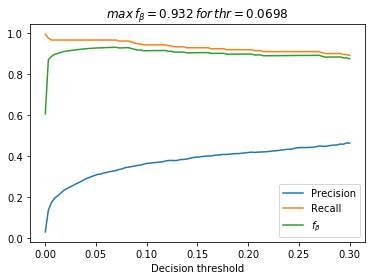

In [6]:
y_pred_val = pipe2.predict_proba(X_val)[:,1]

lx = np.linspace(0.0001,.3,100)
f_p = np.vectorize(lambda thr: precision_score(y_val, y_pred_val>thr))
f_r = np.vectorize(lambda thr: recall_score(y_val, y_pred_val>thr))
f_b = np.vectorize(lambda thr: fbeta_score(y_val, y_pred_val>thr, 7.07))
sns.lineplot(lx,f_p(lx), label = "Precision")
sns.lineplot(lx,f_r(lx), label = "Recall")
sns.lineplot(lx,f_b(lx), label = r"$f_\beta$")
plt.xlabel('Decision threshold')
plt.title(fr"$max\,f_\beta={f_b(lx).max():3.3} \,for\, thr={lx[f_b(lx).argmax()]:3.3}$")
plt.legend()
plt.show()

# export predictions

In [7]:
XGB_model_optimal_params = xgb.XGBClassifier(objective='binary:logistic',
                       max_depth=3,
                        learning_rate=0.1,
                        base_score =0.95,
                        gamma=0.3,
                        reg_alpha=0.3,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        n_estimators=500,
                        scale_pos_weight = pos_weight
                        ,n_jobs=4
                        ,gpu_id = 0
                        ,max_bin = 16
                        ,tree_method = 'gpu_hist')
pipe2 = make_pipeline(normalizer, imputer, standardizer, XGB_model_optimal_params)
pipe2.fit(*split_x_y(df))

Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function normalize_histograms_in_df at 0x7f54d497f0d0>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('imputer', Imputer(axis=0...da=1, scale_pos_weight=59.0, seed=None, silent=True,
       subsample=0.9, tree_method='gpu_hist'))])

In [8]:
y_pred = pipe2.predict_proba(df_test)[:,1]>0.07

df_predictions = pd.DataFrame(y_pred.astype(int), index = df_test.index, columns = ["Predicted"])
df_predictions.to_csv('XGB_submission_balanced.csv')

When submited this prediction yielded a score of 0.94582 in the public leaderboard. 